# Functions

In [6]:
import numpy as np
from mpmath import mp
from tqdm import tqdm
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from utils import save_exponents_csv

mp.dps = 30  # Set desired precision

plus_configs = [
    ([1,1,1], lambda J1, J2: 2*J1 + J2, mp.mpf('3')),
    ([1,1,-1], lambda J1, J2: -J2, mp.mpf('1')),
    ([1,-1,1], lambda J1, J2: -2*J1 + J2, mp.mpf('1')),
    ([-1,1,1], lambda J1, J2: -J2, mp.mpf('1'))
]

minus_configs = [
    ([-1,-1,-1], lambda J1, J2: 2*J1 + J2, mp.mpf('-3')),
    ([-1,-1,1], lambda J1, J2: -J2, mp.mpf('-1')),
    ([-1,1,-1], lambda J1, J2: -2*J1 + J2, mp.mpf('-1')),
    ([1,-1,-1], lambda J1, J2: -J2, mp.mpf('-1'))
]

def get_J(d, J0, n):
    if d <= 0:
        return mp.mpf(0)
    return mp.mpf(J0) / mp.power(mp.mpf(d), mp.mpf(n))

def mp_logsumexp(lst):
    if not lst:
        return mp.ninf
    a_max = max(lst)
    if mp.isinf(a_max):
        return a_max
    tmp = sum(mp.exp(a - a_max) for a in lst)
    return a_max + mp.log(tmp)

def compute_R_logs(start, J_func, h):
    J1 = J_func(1)
    J2 = J_func(2)
    distances = [(iL, iR, (start + iR) - (1 + iL)) for iL in range(3) for iR in range(3)]

    def get_totals(left_confs, right_confs):
        totals = []
        for spinsL, El_func, sumL in left_confs:
            El = El_func(J1, J2)
            for spinsR, Er_func, sumR in right_confs:
                Er = Er_func(J1, J2)
                Eint = mp.mpf('0')
                for iL, iR, d in distances:
                    Eint += mp.mpf(spinsL[iL] * spinsR[iR]) * J_func(d)
                total = El + Er + Eint + h * (sumL + sumR)
                totals.append(total)
        return totals

    totals_pp = get_totals(plus_configs, plus_configs)
    totals_pm = get_totals(plus_configs, minus_configs)
    totals_mp = get_totals(minus_configs, plus_configs)
    totals_mm = get_totals(minus_configs, minus_configs)

    log_R_pp = mp_logsumexp(totals_pp)
    log_R_pm = mp_logsumexp(totals_pm)
    log_R_mp = mp_logsumexp(totals_mp)
    log_R_mm = mp_logsumexp(totals_mm)

    return log_R_pp, log_R_pm, log_R_mp, log_R_mm

def compute_J_prime_func(start, J_func, h):
    log_pp, log_pm, log_mp, log_mm = compute_R_logs(start, J_func, h)
    if mp.isinf(log_pm) or mp.isinf(log_mp):
        return mp.inf
    ln_arg = log_pp + log_mm - log_pm - log_mp
    return mp.mpf('0.25') * ln_arg

def compute_H_prime_func(start, J_func, h): # start = 4 for r'=1
    log_pp, _, _, log_mm = compute_R_logs(start, J_func, h)
    ln_arg = log_pp - log_mm
    return mp.mpf('0.25') * ln_arg

def generate_rg_flow(J0, n, max_k, num_steps):
    J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
    rs = list(range(1, max_k + 1))
    initial_Js = [J_func(r) for r in rs]
    all_Js = [initial_Js]
    all_J_funcs = [J_func]
    h = mp.mpf(0)
    for step in range(1, num_steps + 1):
        Jps = []
        for r in rs:
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func, h)
            Jps.append(Jp)
        all_Js.append(Jps)
        J_dict = {r: Jps[r-1] for r in rs}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        all_J_funcs.append(J_func)
    return all_Js, all_J_funcs

def construct_recursion_matrix(J0, n, max_k, num_steps, matrix_size=5, epsilon=1e-6):
    all_Js, _ = generate_rg_flow(J0, n, max_k, num_steps)
    if len(all_Js) < 2:
        raise ValueError("Need at least 2 steps for derivatives")

    # Extract first matrix_size from last two steps
    J_k_minus_1 = all_Js[-2][:matrix_size]  # list of mp.mpf, truncated
    J_k = all_Js[-1][:matrix_size]  # list of mp.mpf, truncated

    M = matrix_size  # Size of matrix
    jac = np.zeros((M, M))

    # Define compute_T truncated to M
    def compute_T(J_vec_mp):
        J_dict = {r+1: J_vec_mp[r] for r in range(M)}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        J_prime = []
        h = mp.mpf(0)  # h=0
        for r in range(1, M+1):
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func, h)
            J_prime.append(Jp)
        return J_prime

    epsilon_mp = mp.mpf(epsilon)

    J_k_minus_1_float = np.array([float(j) for j in J_k_minus_1])
    J_k_float = np.array([float(j) for j in J_k])

    for s in range(M):
        J_pert_mp = [j for j in J_k_minus_1]  # copy list of mp
        J_pert_mp[s] += epsilon_mp
        T_pert_mp = compute_T(J_pert_mp)
        T_pert_float = np.array([float(j) for j in T_pert_mp])
        jac[:, s] = (T_pert_float - J_k_float) / float(epsilon)

    return jac

def find_J_c(n, max_k=1000, tol=1e-6, J_low=1e-10, J_high=3.0):
    if n <= 0 or n >= 2:
        raise ValueError("n must be between 0 and 2, excluding the edges.")

    start_track = 3
    max_steps = 5
    tol = mp.mpf(tol)
    J_low = mp.mpf(J_low)
    J_high = mp.mpf(J_high)
    rs = list(range(1, max_k + 1))

    def compute_flow(J0):
        J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
        all_Js = [[J_func(r) for r in rs]]
        h = mp.mpf(0)
        for step in range(1, max_steps + 1):
            Jps = [compute_J_prime_func(3 * r + 1, J_func, h) for r in rs]
            all_Js.append(Jps)
            if step >= start_track:
                J_r2_current = Jps[1]
                J_r2_previous = all_Js[-2][1]
                if J_r2_current > J_r2_previous:
                    return all_Js, True  # Growing (ferromagnetic)
                if J_r2_current < J_r2_previous:
                    return all_Js, False  # Decaying (paramagnetic)
            J_dict = {r: Jps[r-1] for r in rs}
            J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        # Fallback
        J_r2_initial = all_Js[0][1]
        J_r2_final = all_Js[-1][1]
        return all_Js, J_r2_final > J_r2_initial

    iter_count = 0
    while J_high - J_low > tol and iter_count < 100:
        iter_count += 1
        J_mid = (J_low + J_high) / 2
        _, is_growing = compute_flow(J_mid)
        if is_growing:
            J_high = J_mid  # Growing: search lower half
        else:
            J_low = J_mid  # Decaying: search upper half
    return (J_low + J_high) / 2

def compute_dH_prime_dH(J0, n, max_k, num_steps, h_small='1e-30'):
    """
    Compute the derivative ∂H'/∂H at low temperature using finite differences.
    
    Parameters:
    J0 (float): Initial coupling strength (high for low temperature)
    n (float): Power-law exponent
    max_k (int): Maximum distance for couplings
    num_steps (int): Number of RG steps to reach fixed point
    h_small (str or float): Small magnetic field perturbation
    
    Returns:
    float: Approximate ∂H'/∂H
    """
    # Generate RG flow to get fixed-point couplings
    all_Js, _ = generate_rg_flow(J0, n, max_k, num_steps)
    J_fixed = all_Js[-1]  # Take the last step as fixed point
    J_func_fixed = lambda d: J_fixed[d-1] if 1 <= d <= max_k else mp.mpf(0)
    
    # Compute H' with small perturbation h_small
    h_small = mp.mpf(h_small)
    H_prime = compute_H_prime_func(4, J_func_fixed, h_small)  # r'=1, start=4
    dH_prime_dH = H_prime / h_small
    
    return float(dH_prime_dH)

def compute_magnetization(J0, n, max_k=500, num_steps=15,
                                 eps=mp.mpf('1e-30'), b=3, d=1):
    """
    Returns M_0 for the ferromagnetic long-range Ising model.
    J0 = 1/T  (larger J0 → lower T)
    """
    rs = list(range(1, max_k+1))

    # ---- initial state -------------------------------------------------
    J_dict = {r: get_J(r, J0, n) for r in rs}
    J_func = lambda d: J_dict.get(d, mp.mpf(0))

    R_factors = []          # will store ∂H′/∂H at each step
    M_n = None

    for step in range(num_steps):
        # ---- derivative ∂H′/∂H at *current* couplings -----------------
        H_plus  = compute_H_prime_func(4, J_func,  eps)   # r'=1 → start=4
        H_minus = compute_H_prime_func(4, J_func, -eps)
        R_k = (H_plus - H_minus) / (2*eps)
        R_factors.append(R_k)

        # ---- renormalise the *couplings* (field = 0) -----------------
        J_new = []
        for r in rs:
            start = 3*r + 1
            Jp = compute_J_prime_func(start, J_func, mp.mpf(0))
            J_new.append(Jp)
        J_dict = {r: J_new[r-1] for r in rs}
        J_func = lambda d: J_dict.get(d, mp.mpf(0))

        # ---- sink detection (after a few steps) -----------------------
        if step > 4:
            J1 = float(J_dict[1])
            if J1 > 1e6:                     # strong coupling → FM sink
                M_n = mp.mpf(1)
                break
            if abs(J1) < 1e-12:               # couplings died → disordered
                M_n = mp.mpf(0)
                break

    if M_n is None:                     # did not converge fast enough
        M_n = mp.mpf(0)

    # ---- back-propagation ---------------------------------------------
    M = M_n
    for R in reversed(R_factors):       # note the *reverse* order
        M = M * R / b                   # b^{-d} = 1/3

    return float(M)

# Beta fitting

Critical Tc for n=1.2: 4.036316515553326
beta = 0.03442777107974525


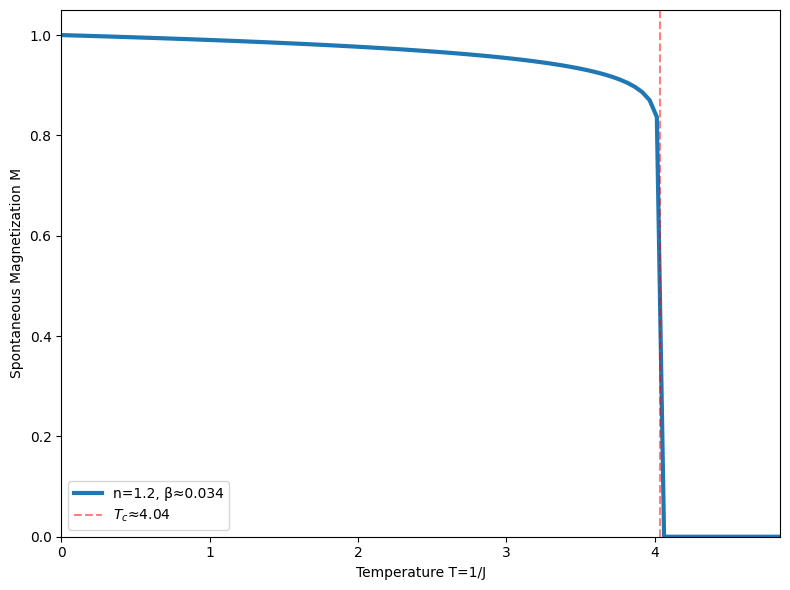

In [5]:
# Parameters
n = 1.2  # Fixed power-law exponent
max_k = 1000
num_steps = 4
matrix_size = 5
b = 3.0  # Rescaling factor

# Find J_c and T_c
Jc = find_J_c(n, max_k=max_k, tol=1e-6, J_low=1e-10, J_high=3.0)
Tc = 1 / float(Jc)
print(f"Critical Tc for n={n}: {Tc}")

# Compute recursion matrix at J_c
M_matrix = construct_recursion_matrix(float(Jc), n, max_k, num_steps, matrix_size=matrix_size)

# Eigenvalues for y_T
eigenvalues = np.linalg.eigvals(M_matrix)
eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
lambda_t = eigenvalues[0]
yT = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0

# Compute y_H
all_Js, _ = generate_rg_flow(float(Jc), n, max_k, num_steps)
J_fixed = all_Js[-1]
J_func_fixed = lambda d: J_fixed[d-1] if 1 <= d <= max_k else mp.mpf(0)
h_small = mp.mpf('1e-30')
H_prime = compute_H_prime_func(4, J_func_fixed, h_small)
dyh = H_prime / h_small
yH = float(mp.log(dyh) / mp.log(mp.mpf('3')))

# Compute beta
beta = (1 - yH) / yT if yT != 0 else np.inf
print(f"beta = {beta}")

# Plot M vs T
T_values = np.linspace(0.01, 1.2 * Tc, 100)  # From near 0 to above Tc
M_values = np.zeros_like(T_values)
for i, T in enumerate(T_values):
    if T < Tc:
        M_values[i] = (1 - T / Tc)**beta

# Create 2D plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T_values, M_values, linewidth=3, label=f'n={n}, β≈{beta:.3f}')
ax.axvline(x=Tc, color='r', linestyle='--', alpha=0.5, label=f'$T_c$≈{Tc:.2f}')
ax.set_xlabel('Temperature T=1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_xlim(0, max(T_values))
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(False)
plt.tight_layout()
#plt.savefig(f'../figures/magnetization_n{n}.png')
plt.show()

### Multiple a values

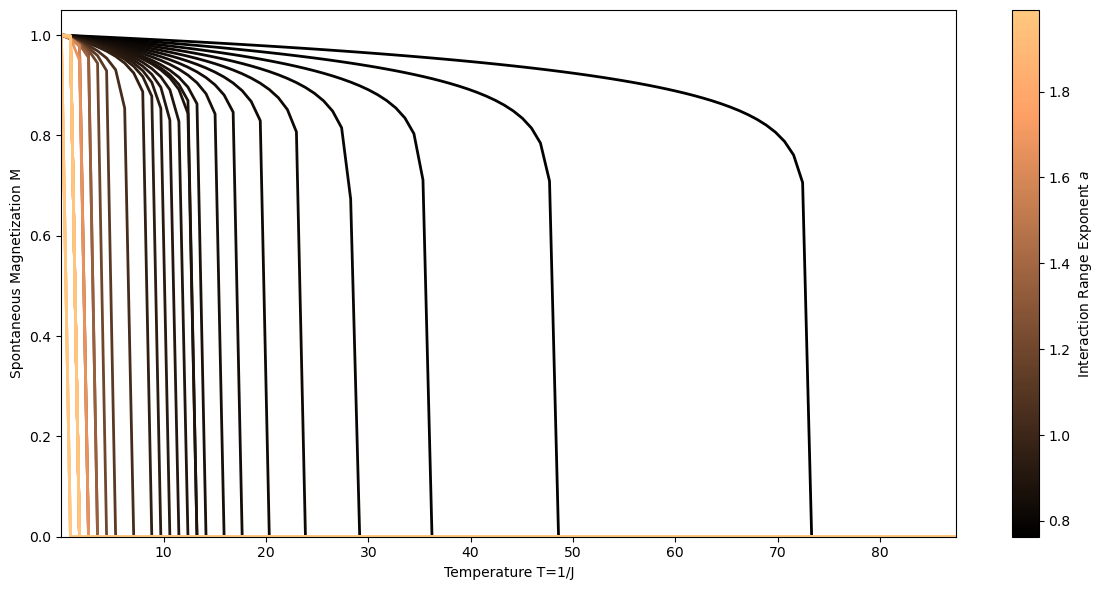

In [100]:
import matplotlib.cm as cm

# Compute T_c and beta for each n
Tcs = 1 / Jcs
betas = etas * nus  # beta = eta * nu = (1 - y_H) / y_T

# Set up temperature range
num_T = 100
T_min = 0.01
T_max = np.max(Tcs) * 1.2  # Slightly above max Tc
T_values = np.linspace(T_min, T_max, num_T)

# Compute M for each n
M_values = np.zeros((num_T, len(n_values)))
for i, (Tc_i, beta_i) in enumerate(zip(Tcs, betas)):
    for j, T in enumerate(T_values):
        if T < Tc_i:
            M_values[j, i] = (1 - T / Tc_i) ** beta_i
        else:
            M_values[j, i] = 0  # M = 0 for T >= Tc

# Create 2D plot with multiple curves using colormap
fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.copper # Colormap
norm = plt.Normalize(min(n_values), max(n_values))  # Normalize n to colormap range

for i, n_i in enumerate(n_values):
    ax.plot(T_values, M_values[:, i], linewidth=2, color=cmap(norm(n_i)))

# Add colorbar to indicate n values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label='Interaction Range Exponent $a$')

ax.set_xlabel('Temperature T=1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_ylim(0, 1.05)
ax.set_xlim(T_min, T_max)
ax.grid(False)
plt.tight_layout()
plt.savefig(f'../figures/magnetization_all_n.png')
plt.show()